## 04.P Geospatial Data Problem Set – Summarizing Airborne Snow Observatory Data

__Background:__ For your graduate research, you are using lidar-derived snow water equivalent (SWE) estimates to assimilate into a physics based hydrology model to make streamflow predictions. In thinking through your hypotheses portions of the landscape where SWE data will have the most impact, you are reminded of a figure you saw in a presentation at a recent meeting. The figure shows how the distribution of SWE and land area across a range of elevation interact to control the distribution of water storage in the landscape. The figure looked like the following:

<img src='../img/aso_swe.png' alt='Upper Colorado ASO Analysis' width='750' style='display: block; margin: 0 auto'/>

You already have grids of estimated SWE from the Airborne Snow Observatory (ASO) for 4 separate dates at a 50 m spatial resolution, and a coregistered digital elevation model of the study area – the East River in the Colorado Rocky Mountains.  

__Task:__ Use the skills you've developed and the example notebooks you've examined in this module to create an image like the above. The ASO and coregistered DEM can be found in [this Google Drive folder](https://drive.google.com/drive/u/0/folders/1SkjOWPPJe5N25arCW6qbf2ZJWQsrUAAp). Use any of the four ASO files, which corresponds to 2 different dates in 2018 or 2019, or write your code generically to plot any or all dates. You should only need `rasterio`, `numpy`, and `matplotlib` to create this figure.    

In [ ]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
import math as math
from datetime import datetime

#just running through this with 2018 march 31, but this feels like a similar string issue to the first problem set. We know that the prefix for this is going to be
#"ASO_50M_SWE_USCOGE_" with a "Y %m %d" string attached


sample_dates = [20180331, 20180524, 20190407, 20190610] # vector of dates YYYYMMDD; note that 20190407 has errors within it

prefix = 'ASO_50M_SWE_USCOGE_'
path = '/Users/scootty/Desktop/Repositories/sf-GEOS505/Unit04-Geospatial-Data/'
suffix = '.tif'

date_selection = 3 #index position of date you want to run
assert isinstance(date_selection, int), "date_selection must be an integer index."
assert 0 <= date_selection < len(sample_dates), f"date_selection must be between 0 and {len(sample_dates)-1}."
date_obj = datetime.strptime(f"{int(sample_dates[date_selection])}", "%Y%m%d").date()

aso_fname = f'{path}{prefix}{sample_dates[date_selection]}{suffix}'
DEM = rio.open("/Users/scootty/Desktop/Repositories/sf-GEOS505/Unit04-Geospatial-Data/coge_dem_50m.tif")



There are a couple of 0s that should be -9999's in here, but we dont have a good way to find the edge of where the data actually starts in the ASO array. 

Just spitballing a potential approach to resolving this kind of edge-finding case... if you could check the cardinal neighborhood of a cell, we could build out the edge. 


in array of rows R and columns C
begin in first row of the array searching right until you encounter a non-zero value at $R_C$
iteratively evaluate $R+1{_C}$ and $R+1_{C-1}$, moving down and left when a non-zero is occuring...

this walk feels too slow! what about a search for any 0 that is surrounded by 0s in a 3x3 or 5x5 neighborhood...

[[-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 ...
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]
 [-9999. -9999. -9999. ... -9999. -9999. -9999.]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 924, 'height': 1033, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 13N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mer

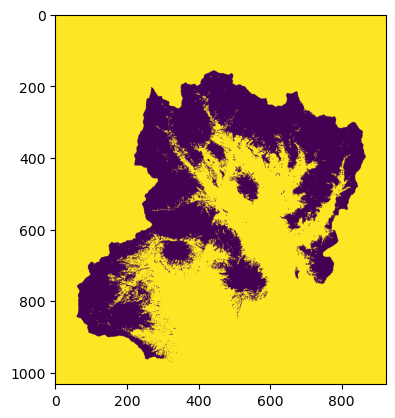

In [ ]:
ASO_array = rio.open(aso_fname)
swe = ASO_array.read(1)

swe_mask = np.isin(swe, [-9999, 0]) #trimming out zeros as well as -9999 values here

print(swe)
print(swe_mask)
plt.imshow(swe)
plt.imshow(swe_mask)
print(ASO_array.meta)

#nice not a swe mask! up to 7m of swe for a 50m pixel
print(np.unique(swe))


Pixel area (m²): 2500.0101089102186
Pixel area (km²): 0.0025000101089102185

Elevation Statistics:
Number of columns [east-west]: 924 
Number of rows [north-south]: 1033
Minimum elevation: 2107.98 m
Maximum elevation: 4337.47 m
Mean elevation: 4337.47 m



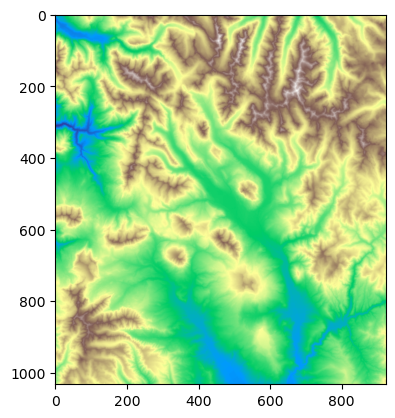

In [138]:
elev_array = DEM.read(1)


pixel_width  = DEM.transform[0]
pixel_height = DEM.transform[4]  # this is negative
pixel_area_m2 = pixel_width * -pixel_height
pixel_area_km2 = pixel_area_m2/1e6
print("Pixel area (m²):", pixel_area_m2)
print("Pixel area (km²):", pixel_area_km2)

zmin = np.nanmin(elev_array)
zmax = np.nanmax(elev_array)
zmean = np.nanmax(elev_array)

zstats = f'''
Elevation Statistics:
Number of columns [east-west]: {elev_array.shape[1]} 
Number of rows [north-south]: {elev_array.shape[0]}
Minimum elevation: {zmin:.{2}f} m
Maximum elevation: {zmax:.{2}f} m
Mean elevation: {zmean:.{2}f} m
'''

print(zstats)

plt.imshow(elev_array, cmap = "terrain")

In [139]:
elev_masked = np.ma.array(elev_array, mask=swe_mask)
swe_masked = np.ma.array(swe, mask=swe_mask)*1000 #converting to mm at this step

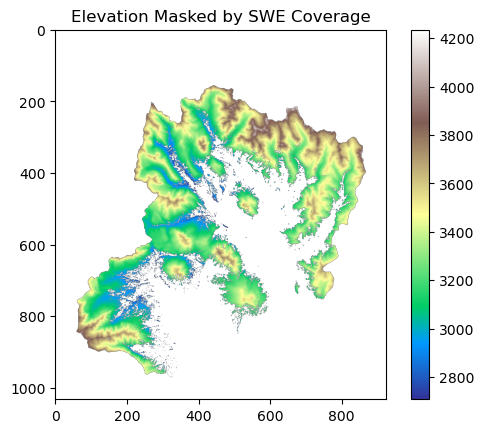

In [140]:
#lets just see if we can look at elev within the swe mask, we know we want 2100 to 4350, 45x50m bins?
plt.imshow(elev_masked, cmap="terrain")
plt.colorbar()
plt.title("Elevation Masked by SWE Coverage")
plt.show()

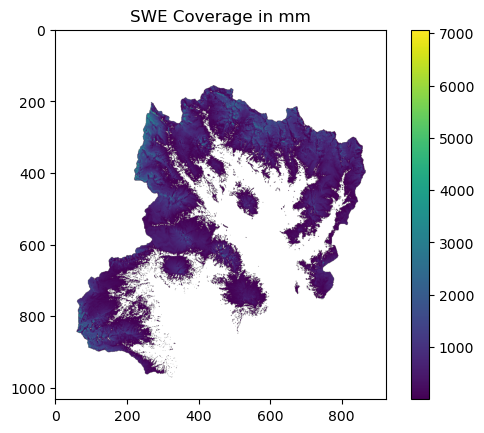

In [141]:
#lets just see if we can look at elev within the swe mask, we know we want 2100 to 4350, 45x50m bins?
plt.imshow(swe_masked, cmap="viridis")
plt.colorbar()
plt.title("SWE Coverage in mm")
plt.show()

Now that I have SWE clipped to elevation, can bin it every 50m for 45 bins (or 46?)

In [ ]:
#45 bins of 50 is 

bin_width = 50
num_bins = 45


zmin = elev_masked.min()
zmax = elev_masked.max()

elev_bins = np.linspace(zmin, zmin + num_bins*bin_width, num_bins+1)
z_plot = (elev_bins[:-1] + elev_bins[1:]) / 2 #   + bin_width / 2

print(elev_bins.shape)
print(z_plot.shape)


In [145]:
#SWE plot
mean_swe_per_band = np.zeros(num_bins)

for i in range(num_bins):
    z_low  = elev_bins[i]
    z_high = elev_bins[i+1]
    in_band = (~swe_masked.mask) & (elev_masked >= z_low) & (elev_masked < z_high)
    band_swe = swe_masked[in_band]
    if band_swe.size == 0:
        mean_swe_per_band[i] = np.nan
    else:
        mean_swe_per_band[i] = np.mean(band_swe)


print(mean_swe_per_band)


[   9.41081145   12.98970047   17.75796079   22.41611562   40.90188954
   74.1917672   109.00808118  141.57167218  165.47267441  240.6736986
  290.01478207  369.39341744  444.83357917  543.97357592  642.98110914
  743.76166253  826.05559531  907.90788678  940.06648766  971.23994386
 1011.05694737 1056.98581353 1080.04749943 1106.34279645 1005.416429
 1056.84875177 1054.53567216 1133.49291893  997.29886432  862.91036258
  833.32468271           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan]


I have pixel area in km, now I need to count # of pixels in each bin to get area in km

since elev_aray is just the raw elevations for each cell, and the masked is a boolean of if its in our swe boundary or not, I just need to write a loop that checks to see if a given cell is between the floor and ceiling of a given bin.

In [146]:
#some sanity checking
print(elev_masked.shape)
print(elev_array)
print(elev_array.shape)

(1033, 924)
[[2495.036  2530.71   2547.77   ... 3075.6199 3092.188  3129.7156]
 [2495.6348 2511.6418 2537.8691 ... 3089.9512 3105.079  3141.3123]
 [2477.9253 2494.5242 2523.0723 ... 3118.3022 3132.356  3155.314 ]
 ...
 [3035.5447 3047.5757 3061.877  ... 3229.3674 3236.9766 3254.6072]
 [3032.926  3052.7595 3059.8423 ... 3223.512  3230.5378 3248.7048]
 [3024.7556 3038.9238 3044.465  ... 3224.7405 3233.366  3246.6362]]
(1033, 924)


In [147]:
area_per_band_km2 = np.zeros(num_bins)
area_per_band_m2 = np.zeros(num_bins)

for i in range(num_bins):
    z_low  = elev_bins[i]
    z_high = elev_bins[i+1]
    in_band = (~elev_masked.mask) & (elev_array >= z_low) & (elev_array < z_high)
    pixel_count = np.sum(in_band)
    area_km2 = pixel_count * pixel_area_km2

    area_per_band_km2[i] = area_km2


ax = axd["B"]
#fig, ax = plt.subplots(figsize=(10,8))
ax.barh(
    z_plot,
    area_per_band_km2,
    height=bin_width,
    color='skyblue'
    )
    ax.set_ylim([elev_bins[0], elev_bins[-1]])
    ax.set_xlabel('Area (km$^2$)')


fig, ax = plt.subplots(figsize=(10,8))

ax.barh(
    z_plot,
    mean_swe_per_band,
    height=bin_width,
    color='skyblue'
)

ax.set_ylim([elev_bins[0], elev_bins[-1]])
ax.set_xlabel('Cumulative SWE (mm)')
ax.set_ylabel('Elevation (m)')
ax.set_title('Cumulative SWE vs Elevation')

plt.show()

This is close, but is just cumulative swe, not volume of swe per elevation. Now that I have area per band and swe per band, we can calculate swe volume per band

In [ ]:
volume_m3 = mean_swe_per_band * area_per_band_km2 /1000 # Mm³ per elevation band

volume_m3


print(volume_m3.shape)
print(mean_swe_per_band.shape)
print(area_per_band_km2.shape)
z_plot.shape
z_plot.size

(45,)
(45,)
(45,)


(45,)


ax = ax["C"]

#fig, ax = plt.subplots(figsize=(10,8))

ax.barh(
    z_plot,
    volume_m3,
    height=bin_width,
    color='skyblue'
)

ax.set_ylim([elev_bins[0], elev_bins[-1]])
ax.set_xlabel('Volume of SWE (Mm$^3$)')
ax.set_ylabel('Elevation (m)')
ax.set_title('SWE volume vs Elevation')

plt.show()

Now that I have those two graphs out of the way, I can focus on calculating the statistics for SWE now for the first plot.

45

In [150]:
mean_swe = np.zeros(z_plot.size)
median_swe = np.zeros(z_plot.size)
std_swe = np.zeros(z_plot.size)

for i in range(z_plot.size):
    z_low  = elev_bins[i]
    z_high = elev_bins[i+1]

    # mask for pixels in this elevation band
    in_band = (~swe_masked.mask) & (elev_masked >= z_low) & (elev_masked < z_high)
    
    band_swe = swe_masked[in_band]

    if band_swe.size == 0:
        mean_swe[i] = np.nan
        median_swe[i] = np.nan
        std_swe[i] = np.nan
        continue

    mean_swe[i]   = np.nanmean(band_swe)
    median_swe[i] = np.nanmedian(band_swe)
    std_swe[i]    = np.nanstd(band_swe)

lower_std = mean_swe - std_swe
lower_std = np.maximum(lower_std, 0) #clip for any values below 0
upper_std = mean_swe + std_swe

In [151]:
print(mean_swe)

[   9.41081145   12.98970047   17.75796079   22.41611562   40.90188954
   74.1917672   109.00808118  141.57167218  165.47267441  240.6736986
  290.01478207  369.39341744  444.83357917  543.97357592  642.98110914
  743.76166253  826.05559531  907.90788678  940.06648766  971.23994386
 1011.05694737 1056.98581353 1080.04749943 1106.34279645 1005.416429
 1056.84875177 1054.53567216 1133.49291893  997.29886432  862.91036258
  833.32468271           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan]


SWE is too small - its in meters! resolved by rescaling it after masking

# drafting the appropriate graphing skeleton - could this get stored in an object and called...?

ax = axd["A"]

#fig, ax = plt.subplots(figsize=(10,8))

#SWE median line
ax.plot(median_swe, z_plot, color='green', label='Median', linewidth=2)
#Mean SWE line
ax.plot(mean_swe, z_plot, color='blue', label='Mean', linestyle='--')

ax.fill_betweenx(
    z_plot, 
    lower_std, 
    upper_std, 
    color='blue', 
    alpha=0.3, 
    label='±1 SD'
)
#Labels
ax.set_xlabel('SWE (mm)')
ax.set_ylabel('Elevation (m)')
ax.set_title('SWE vs Elevation')
ax.legend()

plt.show()

# Some notes for plot code

z_plot is our bin centers
elev_bins are the bin edges

subplot_mosaic allows matplotlib to plot multiple axes together in the same fig - relies on ax = axd["N"] argument
.fill_between uses bin centers and the statistics (lower_std and upper_std, for example) to color between the lines
.set_facecolor just changes the background color of the plot
.grid gives us those lovely gridlines

I wanted to mess with the black line step function that outlined the graph but I did not have the patience to mess around with it, I think it mostly just relies on the positions of the elev_bins and z_plot again

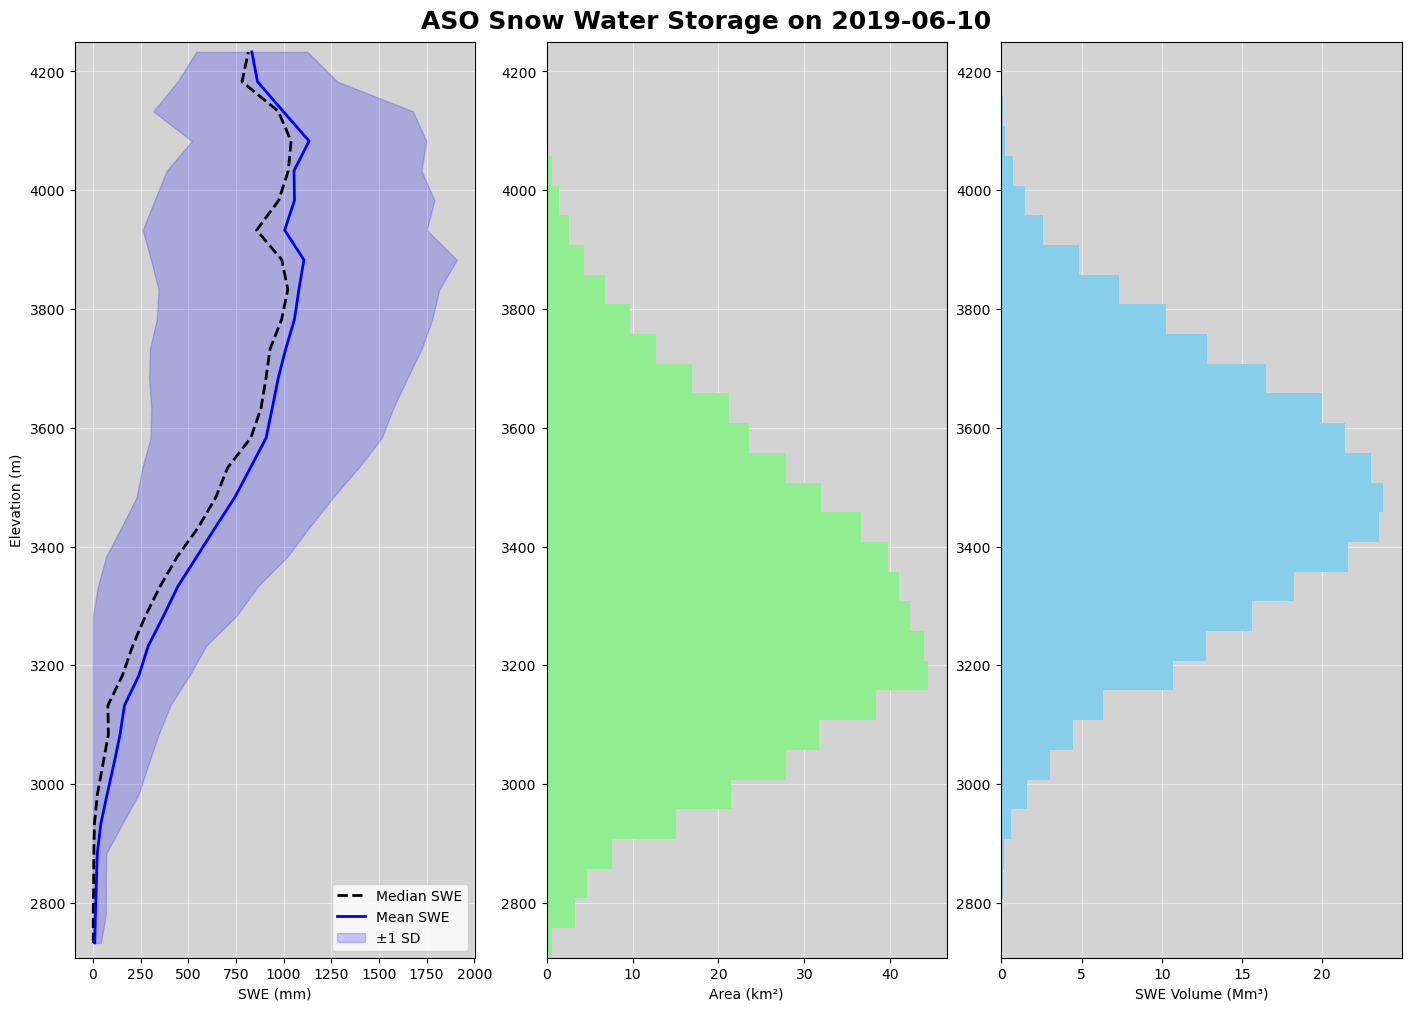

In [ ]:
fig = plt.figure(figsize=(14,10), layout="constrained")
fig.suptitle(f"ASO Snow Water Storage on {date_obj}", fontsize=18, fontweight='bold') #suptitle for labelling all graphs instead of each individually

axd = fig.subplot_mosaic( #this is the code that lets us stack these plots together - each ax = axd argument defines where the graph gets plotted within fig
    """
    ABC
    ABC
    """
)

ax = axd["A"]

ax.plot(median_swe, z_plot, color='black', label='Median SWE', linestyle='--',linewidth=2)
ax.plot(mean_swe, z_plot, color='blue',  linewidth=2, label='Mean SWE')
ax.set_facecolor('lightgrey')
ax.fill_betweenx(
    z_plot,
    lower_std,
    upper_std,
    color='blue',
    alpha=0.2,
    label='±1 SD'
)

ax.set_ylim([elev_bins[0], 4250])
ax.set_xlabel('SWE (mm)')
ax.set_ylabel('Elevation (m)')
ax.grid(True, color = "white", alpha = 0.5)
ax.set_axisbelow(True)
#ax.set_title('SWE vs Elevation')
ax.legend(loc = "lower right")

ax = axd["B"]

ax.barh(
    z_plot,
    area_per_band_km2,
    height=bin_width,
    color='lightgreen')
ax.set_facecolor('lightgrey')
ax.set_ylim([elev_bins[0], 4250])
ax.set_xlabel('Area (km²)')
ax.grid(True, color = "white", alpha = 0.5)
ax.set_axisbelow(True)
#ax.set_ylabel('Elevation (m)')
#ax.set_title('Area vs Elevation')

ax = axd["C"]

ax.barh(
    z_plot,
    volume_m3,
    height=bin_width,
    color='skyblue'
)
ax.set_facecolor('lightgrey')
ax.set_ylim([elev_bins[0], 4250])
ax.set_xlabel('SWE Volume (Mm³)')
ax.grid(True, color = "white", alpha = 0.5)
ax.set_axisbelow(True)
#ax.set_ylabel('Elevation (m)')
#ax.set_title('SWE Volume vs Elevation')
plt.show()
